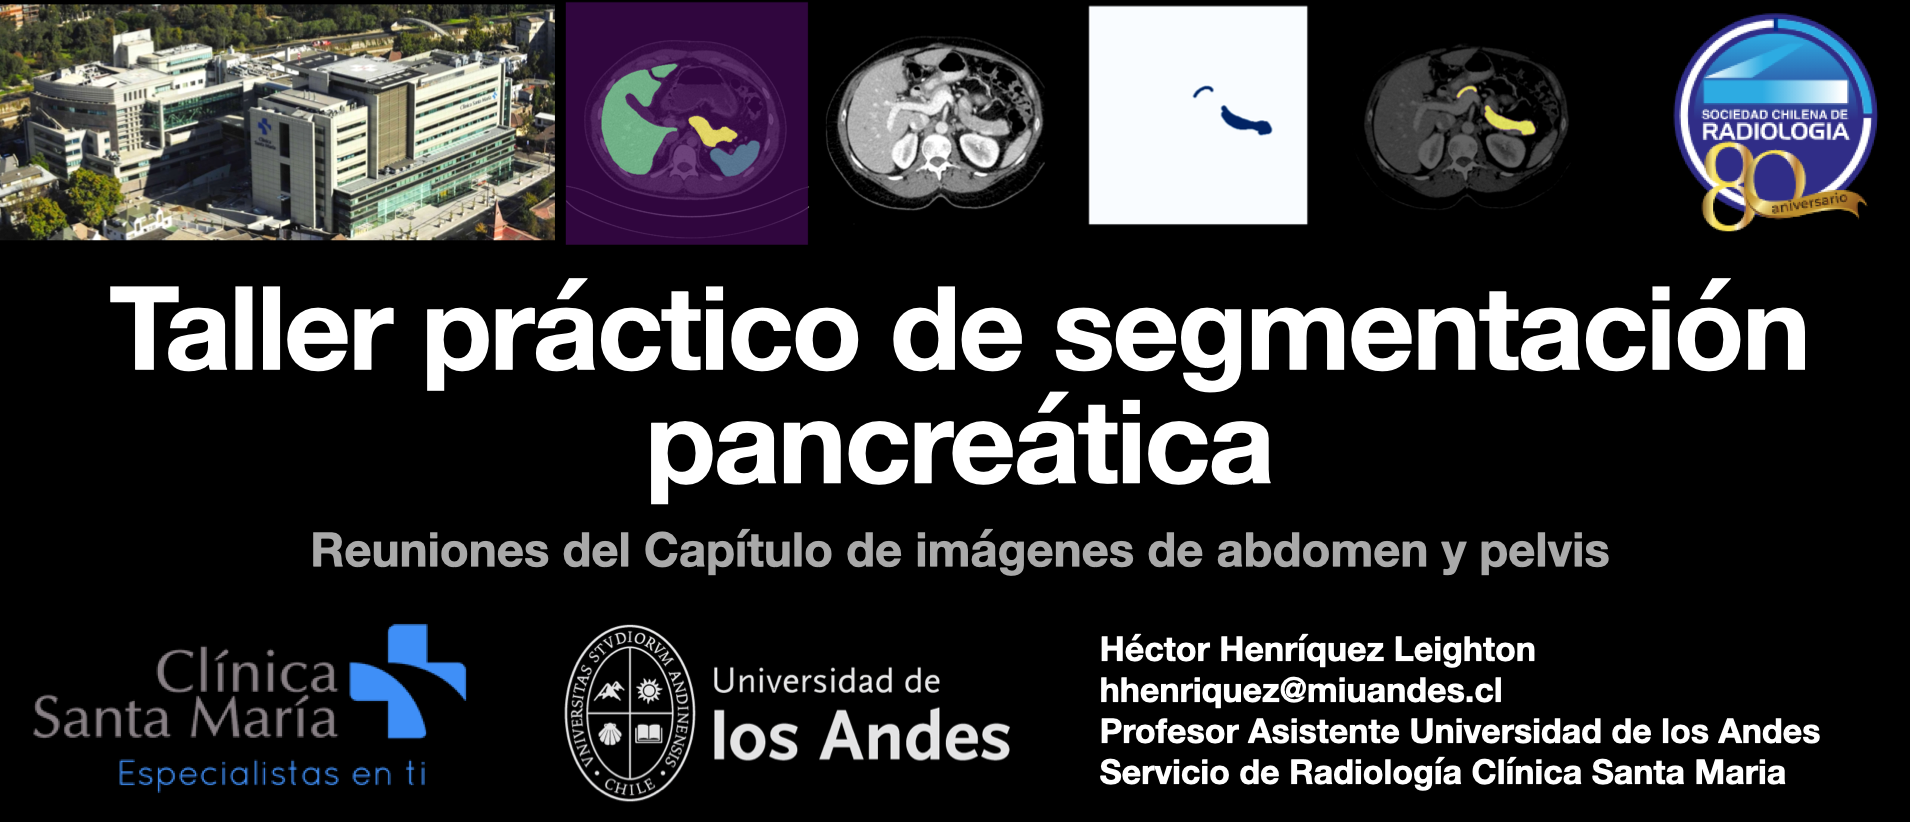

* Dr. Héctor Henríquez Leighton
* 30 de mayo 2023

In [ ]:
!pip install pynrrd
!pip install visualkeras
!pip install seg-metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import trange
import nrrd
import pandas as pd
import visualkeras
import requests
import json
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from sklearn.utils import shuffle

import seg_metrics.seg_metrics as sg
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import BinaryFocalCrossentropy

import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.github.com/HectorHenriquez/pancreatic_segmentation/main/kaggle.json")

token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/pancreatic-segmentation-data

!unzip /content/pancreatic-segmentation-data.zip

In [ ]:
def show_slice_window(slice, level, window):
    
    """
    input: imagen array 2D, 
    permite ajustar ventana y nivel para mejorar contraste de la imagen.
    output: imagen array 2D ventaneada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

def extractImages(data_img, data_mask):
    images = []
    masks = []
    positive_slices = []

    for i in range(data_img.shape[2]):
        segmentation = data_mask[:,:,i]
        if (np.sum(segmentation)>0):
            positive_slices.append(i)

        ## Extrae las imágenes sólo con segmentación - tumor        
    for axial in positive_slices:
        segment = data_mask[:,:,axial]
        ct = data_img[:,:,axial]
        images.append(ct)
        masks.append(segment)

    images = np.array(images)
    masks = np.array(masks)
    return(images, masks)


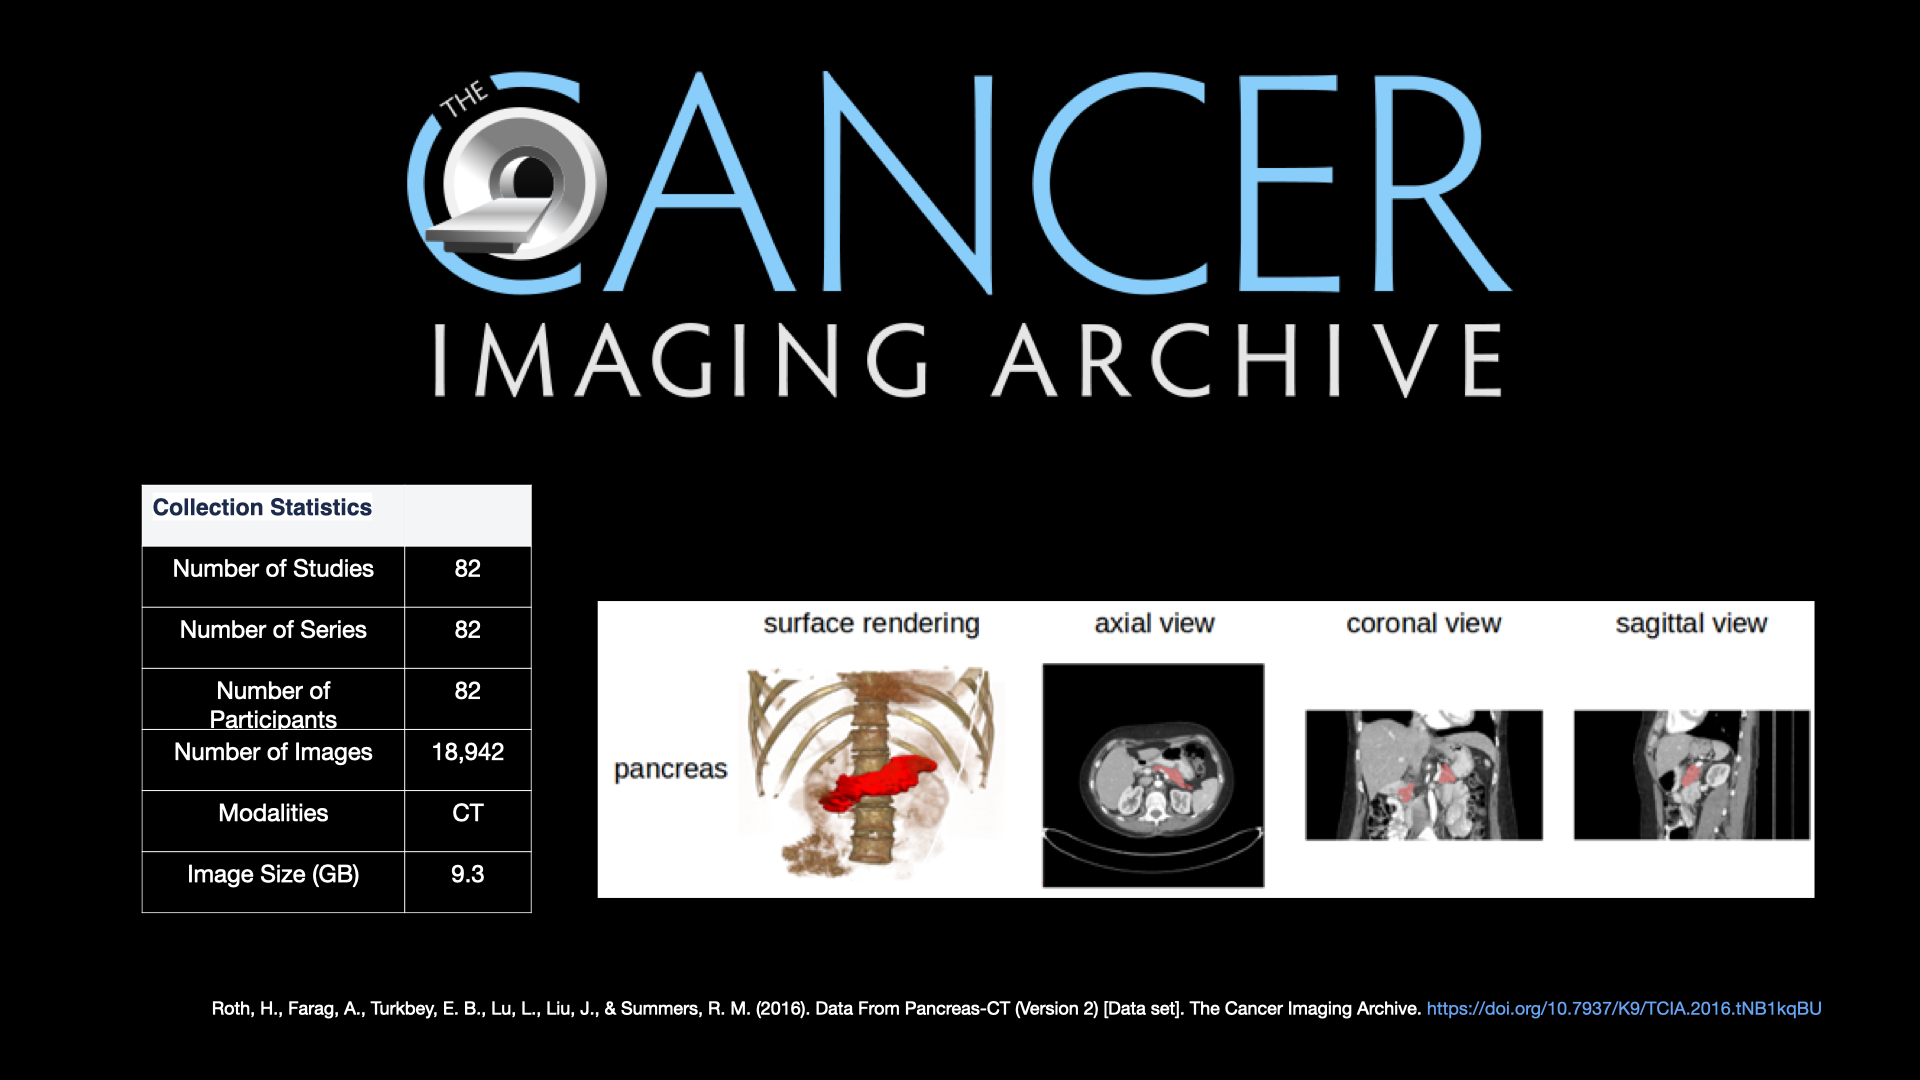

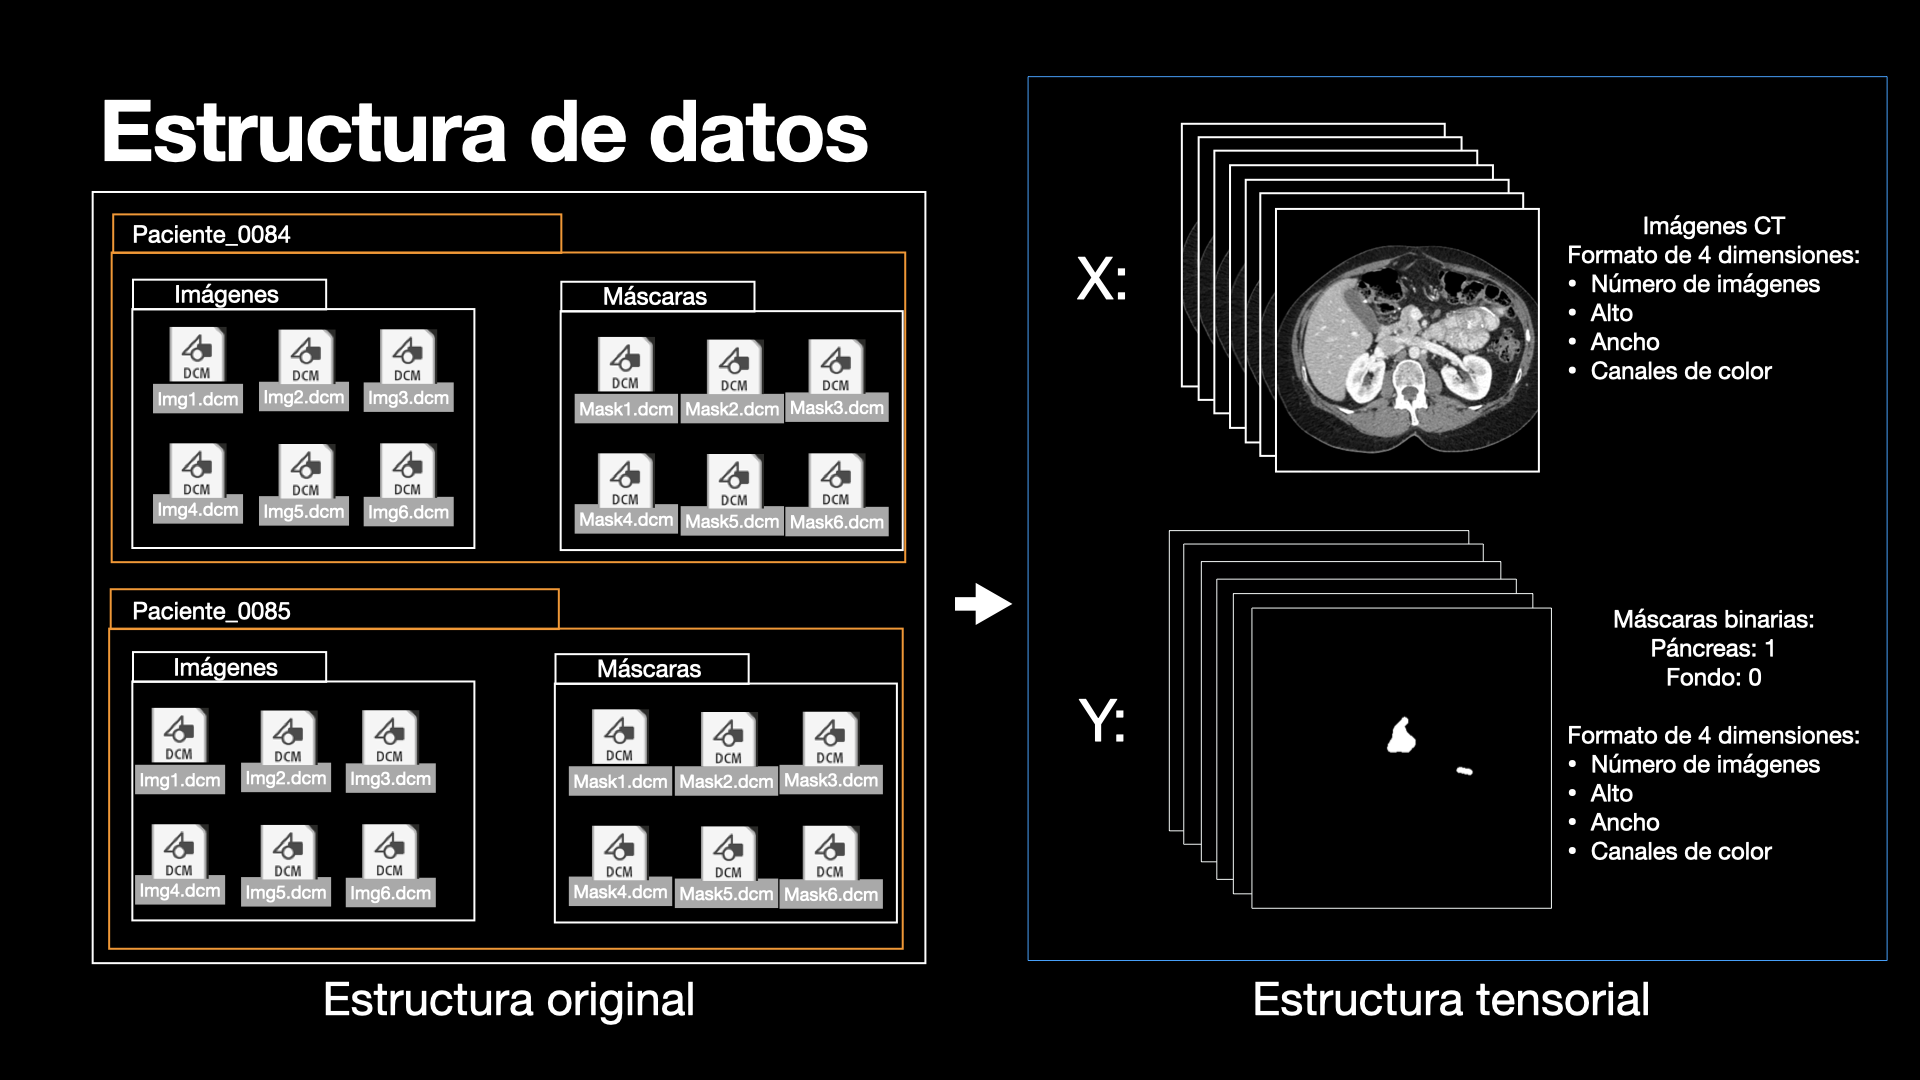

In [ ]:
### Carga del set de datos

data_img, header_img = nrrd.read('/content/pancreatic_segmentation_images128.nrrd', index_order = 'F')

data_mask, header_mask = nrrd.read('/content/pancreatic_segmentation_masks128.nrrd', index_order = 'F')

print(data_img.shape)
print(data_mask.shape)

In [ ]:
index = np.random.randint(0, data_img.shape[0])

img = data_img[index]
mask = data_mask[index]


f = plt.figure(figsize=(10,10), frameon=True)

f.add_subplot(1, 3, 1)
plt.title("CT")
plt.imshow(show_slice_window(img,50,400), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='Blues')

f.add_subplot(1, 3, 3)
plt.title("Fusion")
plt.imshow(show_slice_window(img,50,400), cmap='gray')
plt.imshow(mask, cmap='gnuplot', alpha= 0.6)

plt.show()

In [ ]:
## Preprocesamiento
data_img = data_img.astype('float32') 
data_mask = data_mask.astype('float32')

## Normalización del valor de los pixeles
data_img = (data_img  - np.mean(data_img)) / np.std(data_img)
    
## Reshape
data_img = data_img.reshape(data_img.shape[0],data_img.shape[1],data_img.shape[2],1)
data_mask = data_mask.reshape(data_mask.shape[0],data_mask.shape[1],data_mask.shape[2],1)

print("data_img:", data_img.shape)
print("data_mask:", data_mask.shape)

## Separación de datos de train y test

## Entrenamiento:
X_train = data_img[0:5580,:,:,:]
y_train = data_mask[0:5580,:,:,:]

## Test
X_test = data_img[5580:,:,:,:]
y_test = data_mask[5580:, :,:,:]

## Suffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=5)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Construcción del Modelo de Segmentación



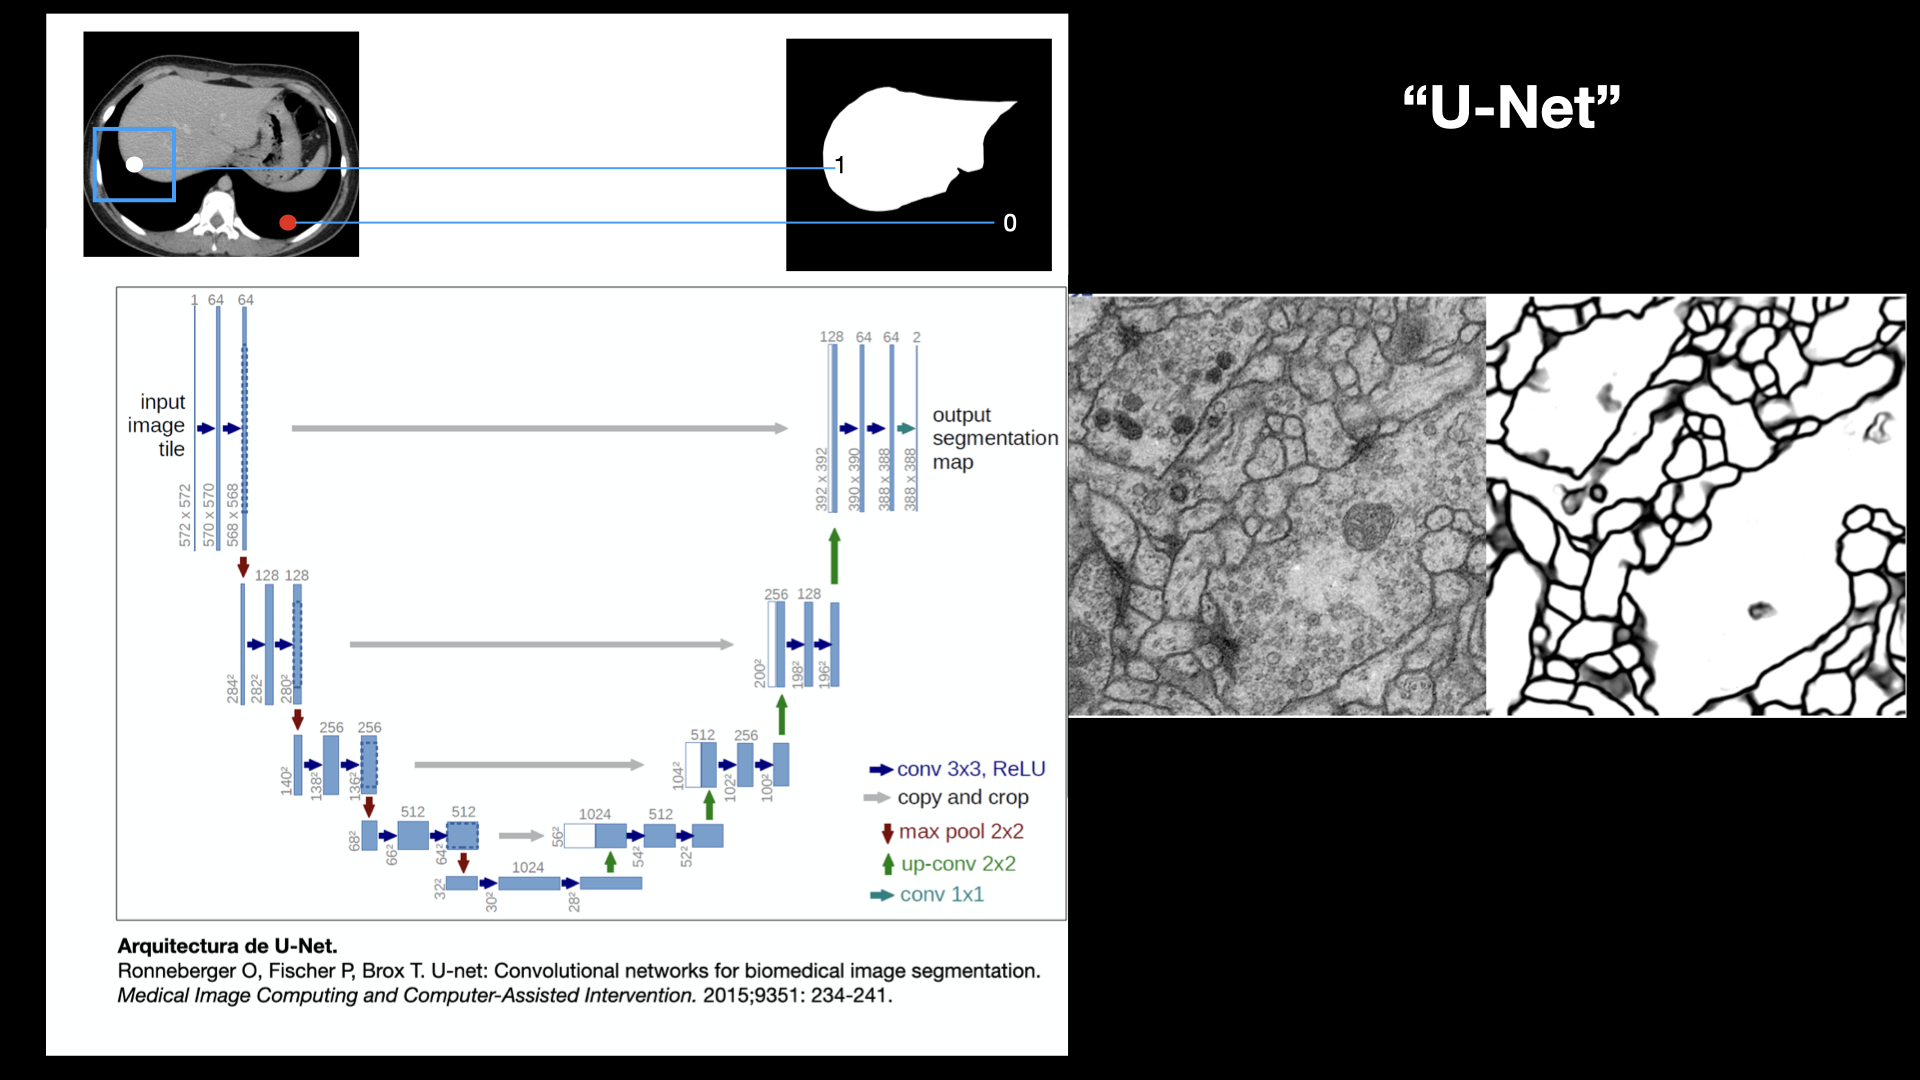

In [ ]:
### Modelo de U-Net

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(1, 1, padding="same", activation="sigmoid")(x8)

    return Model(inputs, output)


In [ ]:
## Creación del Modelo

model = build_unet((128,128,1))

visualkeras.layered_view(model, legend=True, draw_volume=True,spacing=5, type_ignore=[BatchNormalization, Activation])

In [ ]:
#model.summary()

In [ ]:
### Entrenar el Modelo

EPOCHS = 15
BATCH_SIZE = 8
LR = 0.005

### Configuración de Callbacks:
def scheduler(epoch, learning_rate):
    if epoch < 3:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.05)
lr_scheduler = LearningRateScheduler(scheduler)

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Compilado y entrenamiento
model.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy')

history = model.fit(X_train, y_train, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE, 
                validation_split=0.2, shuffle= True,
                callbacks=[lr_scheduler, model_checkpoint_callback])


In [ ]:
### Graficando la función de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
### Creación de prediccines en conjunto de test
predicciones = model.predict(X_test)
predicciones_bin = np.where(predicciones > 0.2, 1,0)

In [ ]:
index = np.random.randint(0, X_test.shape[0])

img = X_test[index]
mask = y_test[index]

f = plt.figure(figsize=(10,10), frameon=False)

f.add_subplot(1, 3, 1)
plt.title("CT")
plt.imshow(show_slice_window(img,1.2,0.8), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Mask-Ground Truth")

plt.imshow(mask, cmap='Blues')

f.add_subplot(1, 3, 3)
plt.title("Fusión Predicción Modelo")
plt.imshow(show_slice_window(img,1.2,0.8), cmap='gray')
plt.imshow(predicciones_bin[index], cmap='gnuplot', alpha= 0.35)

plt.show()

In [ ]:
### Evaluación
metrics = sg.write_metrics(labels=[0,1],
                  gdth_img=mask,
                  pred_img=predicciones_bin[index],
                  csv_file=None,
                  spacing=None,
                  metrics=['dice', 'jaccard'])

f = plt.figure(figsize=(15,15), frameon=False)
f.add_subplot(1, 3, 1)
plt.title("CT + GoundTruth")
plt.imshow(show_slice_window(img,1.3,.7), cmap='gray')
plt.imshow(mask, cmap='gray', alpha= 0.4)

f.add_subplot(1, 3, 2)
plt.title("Predicción")
plt.imshow(show_slice_window(img,1.3,.7), cmap='gray')
plt.imshow(predicciones_bin[index], cmap='gnuplot', alpha=0.4)

f.add_subplot(1, 3, 3)
plt.title("Evaluación Modelo: GT vs Predicción")
plt.imshow(mask, cmap='Blues')
plt.imshow(predicciones_bin[index], cmap='gray', alpha= 0.35)
plt.text(82, 10, "Dice Score: {}".format(round(metrics[0]['dice'][1],2)), size=12, va="center", ha="center", rotation=0)
plt.text(80, 20, "Jaccard Score: {}".format(round(metrics[0]['jaccard'][1],3)), size=12, va="center", ha="center", rotation=0)
plt.text(87, 30, "Accuracy: {}".format(round(accuracy_score(mask.flatten(), predicciones_bin[index].flatten()),3)), size=12, va="center", ha="center", rotation=0)
plt.show()